In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install monai==1.3.0 nibabel SimpleITK scikit-learn pandas matplotlib
!pip install itk
!pip install -q monai[itk] SimpleITK itk

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.8 MB/s eta 0:00:00
  Attempting uninstal

In [ ]:
import os
import pandas as pd
import numpy as np
import SimpleITK as sitk
from sklearn.model_selection import train_test_split
import itk
print(itk.Version.GetITKVersion())
from monai.transforms import Compose, LoadImage, EnsureChannelFirst, ScaleIntensity, Resize, ToTensor
from monai.data import ITKReader
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from monai.networks.nets import DenseNet121
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

5.4.4


In [ ]:
# Correct paths
project_root = "/content/drive/MyDrive/prostate_project"
images_dir = os.path.join(project_root, "mri_images")
clinical_data_path = os.path.join(project_root, "marksheet.csv")
labels_dir = os.path.join(project_root, "picai_labels-main")

# Load clinical data
clinical_df = pd.read_csv(clinical_data_path)
# Convert 'case_csPCa' from 'YES'/'NO' to 1.0/0.0
clinical_df['case_csPCa'] = clinical_df['case_csPCa'].map({'YES': 1.0, 'NO': 0.0})

In [ ]:
data_list = []

# Get list of all files in the images directory
all_files = []
for root, _, files in os.walk(images_dir):
    for file in files:
        all_files.append(os.path.join(root, file))

for idx, row in clinical_df.iterrows():
    patient_id = row["patient_id"]
    # Construct the folder path for the current patient
    folder = os.path.join(images_dir, str(patient_id))

    # Find the paths for t2w, hbv, and adc images for the current patient
    t2w_path = [f for f in all_files if f.startswith(os.path.join(folder, str(patient_id))) and "t2w" in f.lower()][0]
    hbv_path = [f for f in all_files if f.startswith(os.path.join(folder, str(patient_id))) and "hbv" in f.lower()][0]
    adc_path = [f for f in all_files if f.startswith(os.path.join(folder, str(patient_id))) and "adc" in f.lower()][0]

    label = row["case_csPCa"]

    if not (os.path.exists(t2w_path) and os.path.exists(hbv_path) and os.path.exists(adc_path)):
        continue

    data_list.append({
        "t2w": t2w_path,
        "hbv": hbv_path,
        "adc": adc_path,
        "label": label
    })

print(f"Total usable cases: {len(data_list)}")

# 80-20 train-test split
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42, stratify=[d["label"] for d in data_list])
print(f"Train cases: {len(train_data)} | Test cases: {len(test_data)}")

Total usable cases: 1500
Train cases: 1200 | Test cases: 300


In [ ]:
class ProstateDataset(Dataset):
    def __init__(self, data, transforms):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        t2w = self.transforms(item["t2w"])
        hbv = self.transforms(item["hbv"])
        adc = self.transforms(item["adc"])

        image = torch.cat([t2w, hbv, adc], dim=0)
        label = torch.tensor(item["label"], dtype=torch.float32)

        return image, label

In [ ]:
# Transform
def get_middle_slice(image_tensor):
    mid_idx = image_tensor.shape[-1] // 2
    # slice shape: (1, H, W)
    return image_tensor[..., mid_idx]

class ToMiddleSlice:
    def __call__(self, img):
        return get_middle_slice(img)

transforms = Compose([
    LoadImage(image_only=True, reader=ITKReader()),
    EnsureChannelFirst(),
    ScaleIntensity(),
    ToMiddleSlice(), # Apply ToMiddleSlice before Resize
    Resize((128, 128)),
    ToTensor()
])


# DataLoaders
train_dataset = ProstateDataset(train_data, transforms)
test_dataset = ProstateDataset(test_data, transforms)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchvision.models import densenet201
model = densenet201(weights=None).to(device)
# Modify the classifier layer to match the desired output (binary classification)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 1)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
img_path = "/content/drive/MyDrive/prostate_project/mri_images/11152/11152_1001175_t2w.mha"
img = transforms(img_path)
print(img.shape)

torch.Size([1, 128, 128])


In [ ]:
model_dir = os.path.join(project_root, "models")
os.makedirs(model_dir, exist_ok=True)

n_epochs = 6

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # ensure shape (batch_size,1)

        optimizer.zero_grad()

        outputs = model(images)  # shape: (batch_size, 1) logits
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)  # sum loss over batch

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{n_epochs}, Average Loss: {avg_loss:.4f}")

    # Save model every 2 epochs
    if (epoch + 1) % 2 == 0:
        model_path = os.path.join(model_dir, f"densenet201_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Saved model checkpoint: {model_path}")

Epoch 1/6: 100%|██████████| 600/600 [1:08:47<00:00,  6.88s/it]


Epoch 1/6, Average Loss: 0.6202


Epoch 2/6: 100%|██████████| 600/600 [21:01<00:00,  2.10s/it]


Epoch 2/6, Average Loss: 0.6062
Saved model checkpoint: /content/drive/MyDrive/prostate_project/models/densenet201_epoch_2.pth


Epoch 3/6: 100%|██████████| 600/600 [22:10<00:00,  2.22s/it]


Epoch 3/6, Average Loss: 0.5950


Epoch 4/6: 100%|██████████| 600/600 [23:30<00:00,  2.35s/it]


Epoch 4/6, Average Loss: 0.5930
Saved model checkpoint: /content/drive/MyDrive/prostate_project/models/densenet201_epoch_4.pth


Epoch 5/6: 100%|██████████| 600/600 [24:30<00:00,  2.45s/it]


Epoch 5/6, Average Loss: 0.5845


Epoch 6/6: 100%|██████████| 600/600 [23:39<00:00,  2.37s/it]


Epoch 6/6, Average Loss: 0.5776
Saved model checkpoint: /content/drive/MyDrive/prostate_project/models/densenet201_epoch_6.pth


AUC: 0.5643, Accuracy: 0.6633
Confusion Matrix:
[[194  21]
 [ 80   5]]


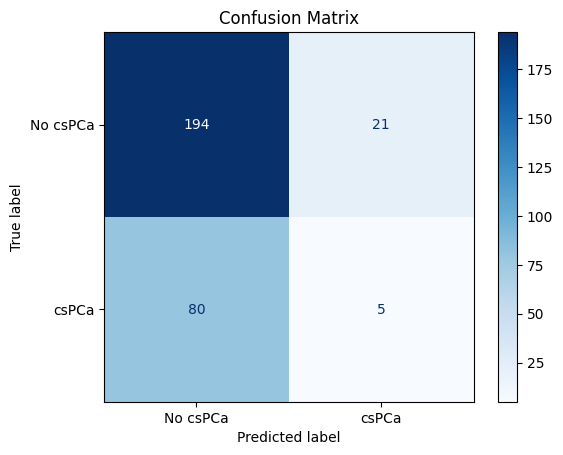

In [ ]:
model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = torch.sigmoid(model(images)).cpu().squeeze()
        y_prob.extend(outputs.numpy())
        preds = np.round(outputs.numpy())
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

auc = roc_auc_score(y_true, y_prob)
accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f"AUC: {auc:.4f}, Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No csPCa", "csPCa"]
    )
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import json
results={
    "model_name": "DenseNet201",
    "train_cases": 1200,
    "test_cases": 300,
    "accuracy":66.33,
      "confusion_matrix": {
        "TP": 194,
        "FP": 21,
        "TN": 80,
        "FN": 5
    }
}
with open("densenet201_results.json","w") as f:
  json.dump(results,f)